# Simple prospective simulation

Prepared by Omar A. Guerrero (oguerrero@turing.ac.uk, @guerrero_oa)

In this tutorial I will demonstrate how to perform a simple prospective analysis by simulating the indicators forward 10 years and measuring the development gaps that would remain open. I will also show how to implement some intuitive visualisations.

## Importing Python's libraries to manipulate and visualise data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Importing PPI's functions

In [2]:
import requests
url = 'https://raw.githubusercontent.com/oguerrer/ppi/main/source_code/ppi.py'
r = requests.get(url)
with open('ppi.py', 'w') as f:
    f.write(r.text)
import ppi

## Load data

Since we are now performing prospective simulations, the initial conditions are the most updated values, i.e. `IF`.

In [3]:
# INDICATORS
df_indis = pd.read_csv('https://raw.githubusercontent.com/oguerrer/ppi/main/tutorials/clean_data/data_indicators.csv')
N = len(df_indis)
I0 = df_indis.IF.values # initial values
R = df_indis.instrumental # instrumental indicators
qm = df_indis.qm.values # quality of monitoring
rl = df_indis.rl.values # quality of the rule of law
indis_index = dict([(code, i) for i, code in enumerate(df_indis.seriesCode)]) # used to build the network matrix
Imax = df_indis.maxVals.values
Imin = df_indis.minVals.values

# PARAMETERS
df_params = pd.read_csv('https://raw.githubusercontent.com/oguerrer/ppi/main/tutorials/clean_data/parameters.csv')
alphas = df_params.alpha.values
alphas_prime = df_params.alpha_prime.values
betas = df_params.beta.values

# NETWORK
df_net = pd.read_csv('https://raw.githubusercontent.com/oguerrer/ppi/main/tutorials/clean_data/data_network.csv')
A = np.zeros((N, N)) # adjacency matrix
for index, row in df_net.iterrows():
    i = indis_index[row.origin]
    j = indis_index[row.destination]
    w = row.weight
    A[i,j] = w

# DISBURSEMENT SCHEDULE (make sure that the disbursement schedule is consistent with T, otherwise PPI will simulate the T of the calibration)
T = 30
df_exp = pd.read_csv('https://raw.githubusercontent.com/oguerrer/ppi/main/tutorials/clean_data/data_expenditure.csv')
Bs_retrospective = df_exp.values[:,1::] # disbursement schedule (assumes that the expenditure programmes are properly sorted)
# Create a new disbursement schedule assuming that expenditure will be the same as the last period of the sample
Bs = np.tile(Bs_retrospective[:,-1], (T,1)).T

# RELATIONAL TABLE
df_rela = pd.read_csv('https://raw.githubusercontent.com/oguerrer/ppi/main/tutorials/clean_data/data_relational_table.csv')
B_dict = {}
for index, row in df_rela.iterrows():
    B_dict[indis_index[row.seriesCode]] = [programme for programme in row.values[1::][row.values[1::].astype(str)!='nan']]

## Development goals

To measure development gaps, it is necessary to consider the goals that the government has in mind. Here, I establish them randomly by choosing a value between the most recent level of an indicator and its technical upper bound.

In [4]:
goals = np.random.rand(N)*(Imax - I0) + I0

## Simulate

PPI has an inportant stochastic component, so a single model run may not be representative of the average output beaviour. I obviated this in the calibration tutorial as much of the simulation sampling is hidden behind the functions. Here, I would like to be more explicit regarding the Monte Carlo sampling procedure, and how to construct the average time series (across simulations) of the indicators. I will use this information to estrimate the development gaps that will remain in 10 years.

In this tutorial, I wil perform the Monte Carlo simulations in a serial fashion. In other words, I will write an explicit `for` loop that waits for one simulation to finish before beginning a new one. In the next turorials, we will use a function that allows us to parellelise this task.

In [5]:
sample_size = 100 # number of Monte Carlo simulations

outputs = []
for sample in range(sample_size):
    output = ppi.run_ppi(I0, alphas, alphas_prime, betas, A=A, R=R, qm=qm, rl=rl,
                Imax=Imax, Imin=Imin, Bs=Bs, B_dict=B_dict, T=T, G=goals)
    outputs.append(output)

In [6]:
# separate the outputs into lists of time series
tsI, tsC, tsF, tsP, tsS, tsG = zip(*outputs)

# copmute the average time series of the indicators
tsI_hat = np.mean(tsI, axis=0)

# make a new dataframe with the indicators' information
new_rows = []
for i, serie in enumerate(tsI_hat):
    new_row = [df_indis.iloc[i].seriesCode, df_indis.iloc[i].sdg, df_indis.iloc[i].color] + serie.tolist()
    new_rows.append(new_row)
    
df_output = pd.DataFrame(new_rows, columns=['seriesCode', 'sdg', 'color']+list(range(T)))
df_output['goal'] = goals

In [7]:
df_output

,seriesCode,sdg,color,0,1,2,3,4,5,6,...,21,22,23,24,25,26,27,28,29,goal
0,sdg8_unemp,8,#A21942,0.130472,0.131139,0.131735,0.132218,0.132684,1.331838e-01,1.336229e-01,...,1.411272e-01,1.416625e-01,1.421103e-01,1.425756e-01,1.431284e-01,1.436637e-01,1.441552e-01,1.446818e-01,1.451558e-01,0.736262
1,sdg5_familypl,5,#FF3A21,0.204848,0.200526,0.195778,0.189758,0.184586,1.781409e-01,1.719081e-01,...,8.966322e-02,8.449147e-02,7.889530e-02,7.308692e-02,6.685411e-02,6.062131e-02,5.502514e-02,4.942897e-02,4.362059e-02,0.319262
2,sdg11_slums,11,#FD9D24,0.000022,0.000017,0.000012,0.000007,0.000003,9.806961e-07,4.054844e-07,...,3.166269e-07,3.164430e-07,2.112072e-07,3.157075e-07,1.588651e-07,2.633654e-07,1.061552e-07,2.629977e-07,5.787052e-07,0.173125
3,sdg1_wpc,1,#E5243B,0.004766,0.004400,0.004030,0.003641,0.003299,2.933904e-03,2.587712e-03,...,1.838741e-05,1.838727e-05,9.194871e-06,4.386947e-06,1.625678e-09,1.767041e-09,1.731700e-09,2.473857e-09,2.438517e-09,0.536345
4,sdg1_320pov,1,#E5243B,0.549709,0.549415,0.548531,0.547264,0.546056,5.447887e-01,5.437280e-01,...,5.258703e-01,5.247801e-01,5.235718e-01,5.225406e-01,5.215389e-01,5.202422e-01,5.189750e-01,5.177373e-01,5.163816e-01,0.956591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,sdg16_rsf,16,#00689D,0.376286,0.376201,0.376117,0.376029,0.375944,3.758547e-01,3.757696e-01,...,3.745356e-01,3.744518e-01,3.743733e-01,3.742922e-01,3.742205e-01,3.741461e-01,3.740596e-01,3.739785e-01,3.738934e-01,0.475689
68,sdg16_justice,16,#00689D,0.349231,0.349432,0.349702,0.349801,0.349968,3.501518e-01,3.503361e-01,...,3.538380e-01,3.540909e-01,3.543266e-01,3.545624e-01,3.548325e-01,3.551198e-01,3.554758e-01,3.557631e-01,3.560675e-01,0.905778
69,sdg17_govex,17,#19486A,0.459400,0.460440,0.461359,0.462251,0.463264,4.641428e-01,4.651156e-01,...,4.798828e-01,4.808960e-01,4.818554e-01,4.829225e-01,4.838683e-01,4.848681e-01,4.859083e-01,4.868676e-01,4.879886e-01,0.994638
70,sdg17_govrev,17,#19486A,0.647900,0.653063,0.658304,0.662999,0.668240,6.732473e-01,6.774732e-01,...,7.507815e-01,7.559447e-01,7.611079e-01,7.657243e-01,7.711219e-01,7.768318e-01,7.818388e-01,7.871582e-01,7.923995e-01,0.992892


## Visualise

First, we visualise the evolution of the indicators.

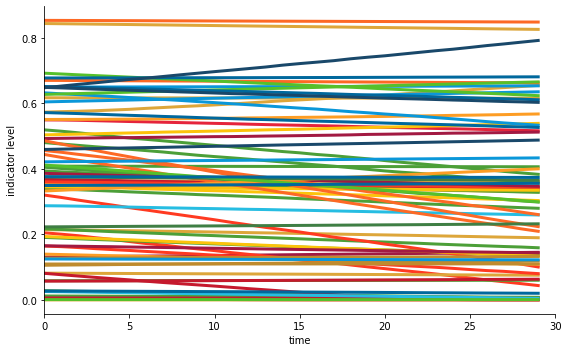

In [8]:
plt.figure(figsize=(8, 5))
for index, row in df_output.iterrows():
    plt.plot(row[range(T)], color=row.color, linewidth=3)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim(0,T)
plt.xlabel('time')
plt.ylabel('indicator level')
plt.tight_layout()

Next, we visualise the evolution of the indicators in terms of their change with regards to the initial conditions.

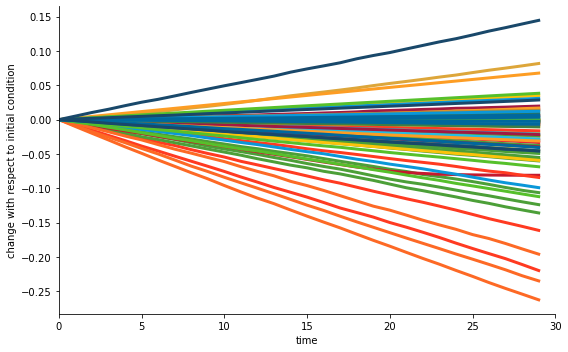

In [9]:
plt.figure(figsize=(8, 5))
for index, row in df_output.iterrows():
    plt.plot(row[range(T)]-row[0], color=row.color, linewidth=3)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim(0,T)
plt.xlabel('time')
plt.ylabel('change with respect to initial condition')
plt.tight_layout()

Now, let's display the final values of the indicators and the goals that the government tried to achieve. The distance between the bars and the dots denote the development gaps that woul remain open in 10 years.

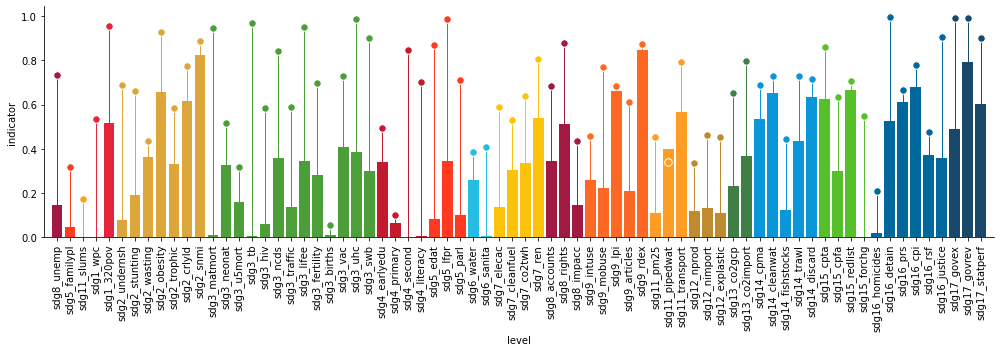

In [10]:
plt.figure(figsize=(14, 5))
for index, row in df_output.iterrows():
    plt.bar(index, row[T-1], color=row.color, linewidth=3)
    plt.plot([index, index], [row[T-1], row.goal], color=row.color, linewidth=1)
    plt.plot(index, row.goal, '.', mec='w', mfc=row.color, markersize=15)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim(-1, N)
plt.xticks(range(N))
plt.gca().set_xticklabels(df_output.seriesCode, rotation=90)
plt.xlabel('level')
plt.ylabel('indicator')
plt.tight_layout()

## Simulated intervention

Finally, let me show an example of a simulated intervention through a gradual increase of goverment expenditure. Let us assume that the government decides to implement linear increments such that, in 10 years, the amount of expenditure triplicates. Here, I show how to implement this intervention through the disbursement schedule and, then how to anlise the difference in development gaps between the baseline prospective and this counterfactual.

In [11]:
linear_growth = np.tile(np.linspace(0, 2, T), (Bs.shape[0],1))
Bs3 = Bs*(1+linear_growth)

outputs = []
for sample in range(sample_size):
    output = ppi.run_ppi(I0, alphas, alphas_prime, betas, A=A, R=R, qm=qm, rl=rl,
                Imax=Imax, Imin=Imin, Bs=Bs3, B_dict=B_dict, T=T, G=goals)
    outputs.append(output)

# separate the outputs into lists of time series
tsI, tsC, tsF, tsP, tsS, tsG = zip(*outputs)

# copmute the average time series of the indicators
tsI_hat = np.mean(tsI, axis=0)

# make a new dataframe with the indicators' information
new_rows = []
for i, serie in enumerate(tsI_hat):
    new_row = [df_indis.iloc[i].seriesCode, df_indis.iloc[i].sdg, df_indis.iloc[i].color] + serie.tolist()
    new_rows.append(new_row)
    
df_output2 = pd.DataFrame(new_rows, columns=['seriesCode', 'sdg', 'color']+list(range(T)))
df_output2['goal'] = goals

Now we compute the development gaps of the baseline and the counterfactual, and present them in a scatter plot to show which indicators respond to the intervention.

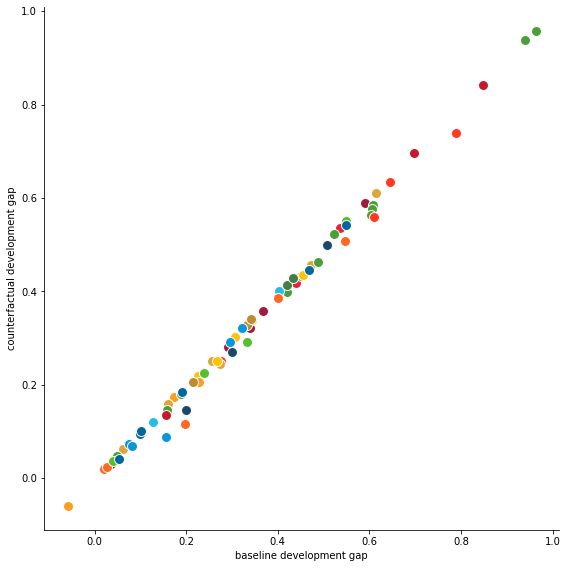

In [18]:
plt.figure(figsize=(8, 8))
for index, row in df_output.iterrows():
    plt.plot(row.goal-row[T-1], df_output2.iloc[index].goal-df_output2.iloc[index][T-1],
             '.', mec='w', mfc=row.color, markersize=20)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlabel('baseline development gap')
plt.ylabel('counterfactual development gap')
plt.tight_layout()